In [43]:
# imports and defines
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import mean_squared_error, mean_absolute_error


DATA_PATH = "Data/" # path to folder with data

In [44]:
# Loading dataset with BTC prices.
btc_price = pd.read_csv(DATA_PATH + 'BTC_data.csv', low_memory = False)
btc_price['timestamp'] = pd.to_datetime(btc_price['timestamp']).dt.tz_localize(None)
print(btc_price.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        720 non-null    datetime64[ns]
 1   price            720 non-null    float64       
 2   returns          720 non-null    float64       
 3   squared_returns  720 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 22.6 KB
None


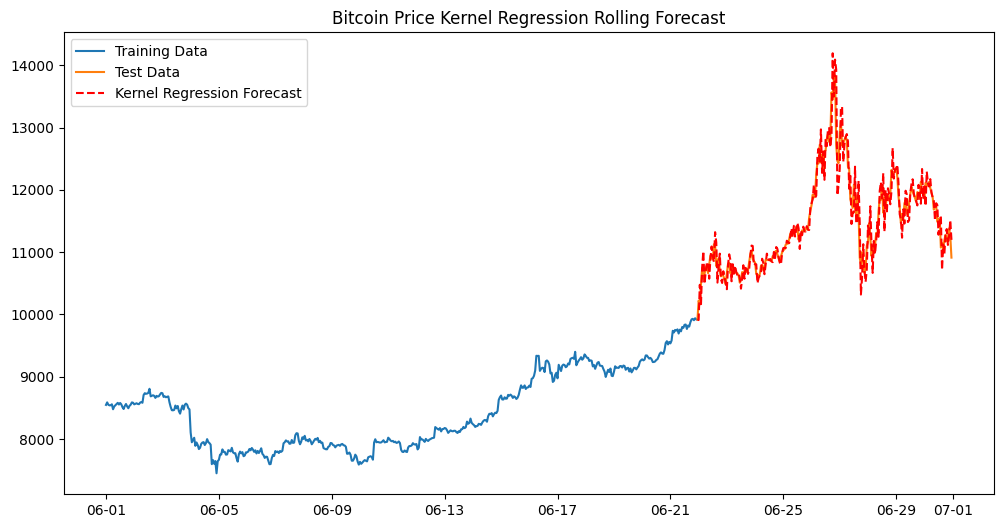

Mean Squared Error: 64558.36
Root Mean Squared Error: 254.08
Mean Absolute Percentage Error: 1.61


In [45]:
# Kernel regression model

def gaussian_kernel(distance, bandwidth):
    return np.exp(-0.5 * (distance / bandwidth) ** 2)

def nadaraya_watson_kernel_regression(X_train, y_train, X_pred, bandwidth=1.0):
    K = gaussian_kernel(euclidean_distances(X_train, X_pred), bandwidth)
    weights = K / np.sum(K, axis=0)
    return np.dot(weights.T, y_train)

train_size = int(len(btc_price) * 0.7)
train, test = btc_price['returns'][0:train_size], btc_price['returns'][train_size:]
train_price, test_price = btc_price['price'][0:train_size], btc_price['price'][train_size:]

history = [x for x in train]
predicted_returns = []

bandwidth = 1.0  # Bandwidth for the Gaussian kernel

# Rolling forecast
for t in range(len(test)):
    X_train = np.arange(len(history)).reshape(-1, 1)
    y_train = np.array(history)
    X_pred = np.array([[len(history)]])
    y_pred = nadaraya_watson_kernel_regression(X_train, y_train, X_pred, bandwidth)
    predicted_returns.append(y_pred[0])
    history.append(test.iloc[t])  # Add actual observation to history for the next iteration

# Convert predicted returns to price levels
predicted_prices = []
for idx, predicted_return in enumerate(predicted_returns):
    actual_price = test_price.iloc[idx-1] if idx > 0 else train_price.iloc[-1]
    predicted_prices.append(actual_price * (1 + predicted_return/100))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(btc_price.timestamp[:train_size], train_price, label='Training Data')
plt.plot(btc_price.timestamp[train_size:], test_price, label='Test Data')
plt.plot(btc_price.timestamp[train_size:], predicted_prices, label='Kernel Regression Forecast', color='red', linestyle='--')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.legend(loc='upper left')
plt.title("Bitcoin Price Kernel Regression Rolling Forecast")
plt.show()

# Calculate MSE
mse = round(mean_squared_error(test_price, predicted_prices), 2)
print('Mean Squared Error:', mse)

# Calculate RMSE
rmse = round(np.sqrt(mse), 2)
print('Root Mean Squared Error:', rmse)

# Calculate MAPE
mape = round(np.mean(np.abs((test_price - predicted_prices) / test_price)) * 100, 2)
print('Mean Absolute Percentage Error:', mape)


Trading strategy:
- Long: If KERNEL REGRESSION predicts a higher closing price than the current close value.
- Short:  If KERNEL REGRESSION predicts a lower closing price than the current close value.
- Neutral: If the prediction is within a threshold.

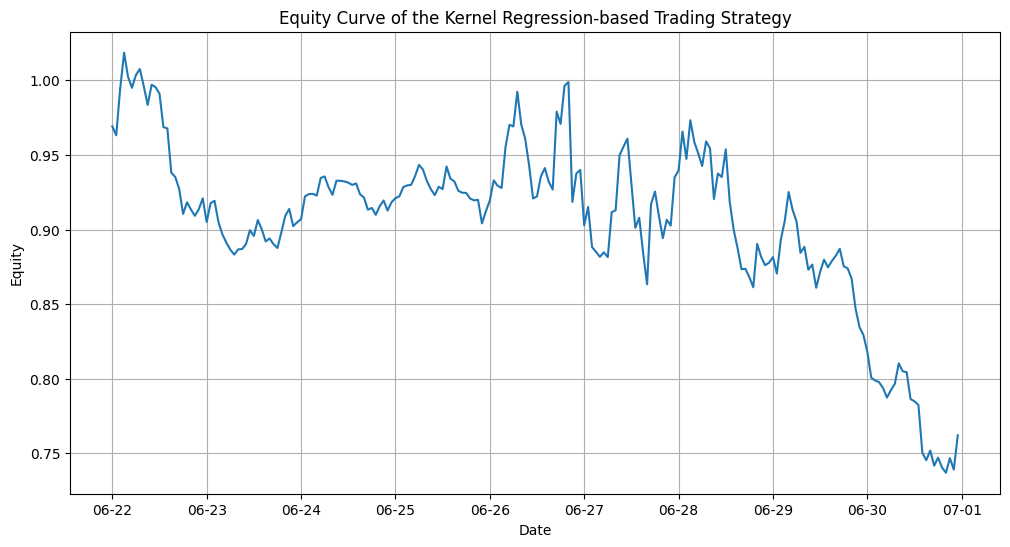

In [46]:
# Simple trading strategy test

signals = [0]  # start with no action
for i in range(1, len(predicted_prices)):
    if predicted_prices[i] > test_price.iloc[i-1]:  # predict higher close
        signals.append(1)  # long
    elif predicted_prices[i] < test_price.iloc[i-1]:  # predict lower close
        signals.append(-1)  # short
    else:
        signals.append(0)  # no action

returns = test_price.pct_change().dropna()  # daily returns
strategy_returns = signals[1:] * returns  # align with the shifted signal

equity_curve = (1 + strategy_returns).cumprod()

# Plot
plt.figure(figsize=(12,6))
plt.plot(btc_price.timestamp[train_size+1:], equity_curve)
plt.title('Equity Curve of the Kernel Regression-based Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Equity')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.grid(True)
plt.show()